In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from contextlib import contextmanager
import time
import os
import sys
import math
import time
import pickle
import psutil
import random
from pathlib import Path


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve,  KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


import seaborn as sns


import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Functions

In [2]:
# ------------------------------------------------------------------------------
# Utilities
# ------------------------------------------------------------------------------
@contextmanager
def timer(name: str):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    try:
        yield
    finally:
        m1 = p.memory_info()[0] / 2. ** 30
        delta = m1 - m0
        sign = '+' if delta >= 0 else '-'
        delta = math.fabs(delta)
        print(f"[{m1:.1f}GB({sign}{delta:.1f}GB): {time.time() - t0:.3f}sec] {name}", file=sys.stderr)


def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


def score_log(df: pd.DataFrame, seed: int, num_fold: int, model_name: str, cv: float):
    score_dict = {'date': datetime.now(), 'seed': seed, 'fold': num_fold, 'model': model_name, 'cv': cv}
    # noinspection PyTypeChecker
    df = pd.concat([df, pd.DataFrame.from_dict([score_dict])])
    df.to_csv(LOG_PATH / f"model_score_{model_name}.csv", index=False)
    return df

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

def img_viewer(data, n):
    if data.shape[0]>n:
        img = data.loc[n].values.reshape(28,28)
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.imshow(img, cmap="gray")
        ax.grid()
        plt.show()
    else:
        print("Error!")

In [40]:
def SingleTraining(classifier, features, target,  title=None, test_size=0.2, random_state=0):
    
    with timer(title):
        X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
        classifier.fit(X_train, y_train)
        preds = classifier.predict(X_test)
        score = accuracy_score(preds, y_test)
        print("Accuracy: {0:.8f}".format(score))
        
        return score
        
def cross_validation(classifier, X_train, y_train, title=None, cv=10, n_jobs=-1):
    with timer(title):
        scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=n_jobs)
        print("Acc Mean: {0:.8f} / Std: {1:.8f}".format(scores.mean(), scores.std()))
        
        return scores

# Loading Data

In [44]:
# Data
train = pd.read_csv('./input/train.csv')
test  = pd.read_csv('./input/test.csv')

target   = train.columns[0]
features = train.columns[1:]

In [45]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [46]:
print(train.isnull().sum().value_counts())
print(test.isnull().sum().value_counts())

0    785
dtype: int64
0    784
dtype: int64


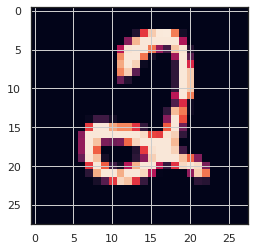

In [51]:
img_viewer(train[features], 34545)

# Data Standardization

- 0~255 -> [0,1]

In [54]:
train[features] = train[features]/255
test[features]  = test[features]/255

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float64(784), int64(1)
memory usage: 251.5 MB


# Model Testing (default)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.2, random_state=0)

In [60]:
clf_cv_list = {}

## 1. Light Gradient Boost Machine (LightGBM)

In [61]:
lgbm_clf = LGBMClassifier()
SingleTraining(lgbm_clf, train[features], train[target],  title='LGBM', test_size=0.2, random_state=0)

Accuracy: 0.97357143


[2.0GB(+0.2GB): 32.949sec] LGBM


0.9735714285714285

In [10]:
kf = KFold(n_splits=10)
scores = []
hyper_params = {'n_jobs':-1,
                'objective': 'multiclass'}
for i, (train_idx, test_idx) in enumerate(kf.split(train)):
    
    X_train = train.iloc[train_idx][features]
    y_train = train.iloc[train_idx][target]
    X_test  = train.iloc[test_idx][features]
    y_test  = train.iloc[test_idx][target]
    
    lgbm_clf = LGBMClassifier(**hyper_params)
    
    lgbm_clf.fit(X_train, y_train, 
                 #eval_set=(X_test, y_test), 
                 #eval_metric='multi_logloss',
                 #early_stopping_rounds=1000,
                 verbose=False)
    
    pred = lgbm_clf.predict(X_test)
    score = accuracy_score(pred, y_test)
    scores.append(score)
print(np.mean(scores), np.std(scores))

0.9743571428571428 0.002610483834529565


In [63]:
X_train, y_train = train[features], train[target]
lgbm_clf = LGBMClassifier()
lgbm_scores = cross_validation(lgbm_clf, X_train, y_train, title='LGBM', cv=10)

Acc Mean: 0.97392857 / Std: 0.00298570


[1.7GB(+0.0GB): 164.032sec] LGBM


In [64]:
clf_cv_list["lgbm_clf"] = lgbm_scores

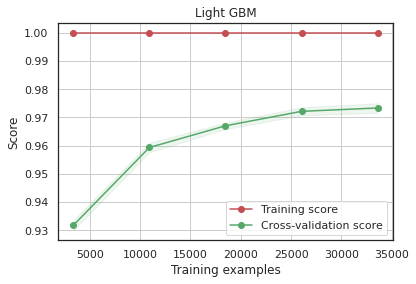

[1.7GB(+0.0GB): 288.957sec] Light GBM (default)


In [65]:
with timer("Light GBM (default)"):
    X_train, y_train = train[features], train[target]
    plot_learning_curve(lgbm_clf, 'Light GBM', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 2. Random Forest

In [66]:
rf_clf = RandomForestClassifier()
SingleTraining(rf_clf, train[features], train[target],  title='Random Forest', test_size=0.2, random_state=0)

Accuracy: 0.96285714


[2.2GB(+0.2GB): 16.302sec] Random Forest


0.9628571428571429

In [67]:
X_train, y_train = train[features], train[target]
rf_clf = RandomForestClassifier()
rf_scores = cross_validation(rf_clf, X_train, y_train, title='Random Forest', cv=10)

Acc Mean: 0.96578571 / Std: 0.00235233


[1.7GB(+0.0GB): 27.562sec] Random Forest


In [68]:
clf_cv_list["rf_clf"] = rf_scores

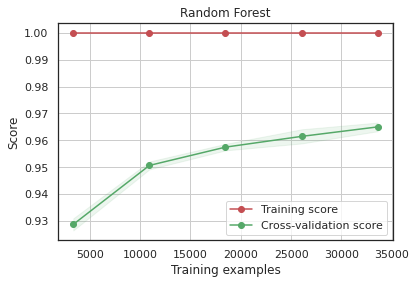

[1.7GB(+0.0GB): 42.210sec] Learning Curve: RF


In [69]:
with timer("Learning Curve: RF"):
    X_train, y_train = train[features], train[target]
    plot_learning_curve(rf_clf, 'Random Forest', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 3. Support Vector Machine (SVM)

In [70]:
svc_clf = SVC()
SingleTraining(svc_clf, train[features], train[target],  title='SVC', test_size=0.2, random_state=0)

Accuracy: 0.97476190


[2.3GB(+0.3GB): 115.571sec] SVC


0.9747619047619047

In [71]:
X_train, y_train = train[features], train[target]
svc_clf = SVC()
svc_scores = cross_validation(svc_clf, X_train, y_train, title='SVC', cv=10)
clf_cv_list['SVC'] = svc_scores

Acc Mean: 0.97676190 / Std: 0.00313202


[1.7GB(-0.0GB): 475.819sec] SVC


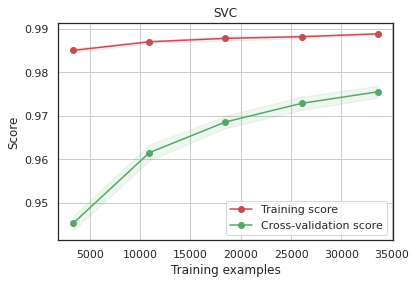

[1.7GB(+0.0GB): 1218.250sec] Learning Curve: SVC


In [26]:
with timer("Learning Curve: SVC"):
    X_train, y_train = train[features], train[target]
    svc_clf = SVC()
    plot_learning_curve(svc_clf, 'SVC', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 4. Decision Tree 

In [72]:
dt_clf = DecisionTreeClassifier()
SingleTraining(dt_clf, train[features], train[target],  title='Decision Tree', test_size=0.2, random_state=0)

Accuracy: 0.85000000


[2.2GB(+0.2GB): 8.214sec] Decision Tree


0.85

In [73]:
X_train, y_train = train[features], train[target]
dt_clf = DecisionTreeClassifier()
dt_scores = cross_validation(dt_clf, X_train, y_train, title='Decision Tree', cv=10)
clf_cv_list['dt_clf'] = dt_scores

Acc Mean: 0.85754762 / Std: 0.00370397


[1.7GB(+0.0GB): 12.547sec] Decision Tree


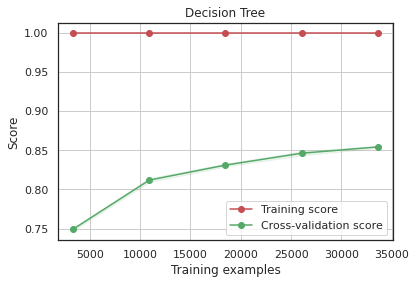

[1.7GB(+0.0GB): 16.750sec] Learning Curve: Decision Tree


In [74]:
with timer("Learning Curve: Decision Tree"):
    X_train, y_train = train[features], train[target]
    dt_clf = DecisionTreeClassifier()
    plot_learning_curve(dt_clf, 'Decision Tree', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 5. k-Nearest Neighbors

In [75]:
kNN_clf = KNeighborsClassifier()
SingleTraining(kNN_clf, train[features], train[target],  title='Decision Tree', test_size=0.2, random_state=0)

Accuracy: 0.96809524


[2.2GB(+0.2GB): 9.464sec] Decision Tree


0.9680952380952381

In [76]:
X_train, y_train = train[features], train[target]
kNN_clf = KNeighborsClassifier()
kNN_scores = cross_validation(kNN_clf, X_train, y_train, title='k-Nearest Neighbors', cv=10)
clf_cv_list['kNN_clf'] = kNN_scores

Acc Mean: 0.96738095 / Std: 0.00302671


[1.7GB(+0.0GB): 23.295sec] k-Nearest Neighbors


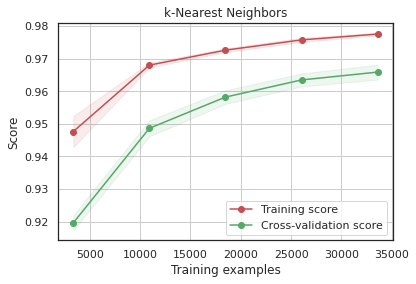

[1.7GB(+0.0GB): 226.748sec] Learning Curve: k-NN


In [77]:
with timer("Learning Curve: k-NN"):
    X_train, y_train = train[features], train[target]
    kNN_clf = KNeighborsClassifier()
    plot_learning_curve(kNN_clf, 'k-Nearest Neighbors', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 6. Gradient Boost Machine

In [38]:
gb_clf = GradientBoostingClassifier()
SingleTraining(gb_clf, train[features], train[target],  title='Gradient Boost', test_size=0.2, random_state=0)

Accuracy: 0.94404762


[2.3GB(+0.3GB): 1044.127sec] Gradient Boost


0.944047619047619

In [ ]:
X_train, y_train = train[features], train[target]
gb_clf = GradientBoostingClassifier()
gb_scores = cross_validation(gb_clf, X_train, y_train, title='Gradient Boost', cv=10)
clf_cv_list['gb_clf'] = gb_scores

In [ ]:
with timer("Learning Curve: Gradient Boost"):
    X_train, y_train = train[features], train[target]
    gb_clf = GradientBoostingClassifier()
    plot_learning_curve(gb_clf, 'Gradient Boost', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 7. AdaBoost

In [78]:
adb_clf = AdaBoostClassifier()
SingleTraining(adb_clf, train[features], train[target],  title='AdaBoost', test_size=0.2, random_state=0)

Accuracy: 0.73821429


[2.2GB(+0.2GB): 22.686sec] AdaBoost


0.7382142857142857

In [79]:
X_train, y_train = train[features], train[target]
adb_clf = AdaBoostClassifier()
adb_scores = cross_validation(adb_clf, X_train, y_train, title='AdaBoost', cv=10)
clf_cv_list['adb_clf'] = adb_scores

Acc Mean: 0.71878571 / Std: 0.01044283


[1.7GB(+0.0GB): 39.683sec] AdaBoost


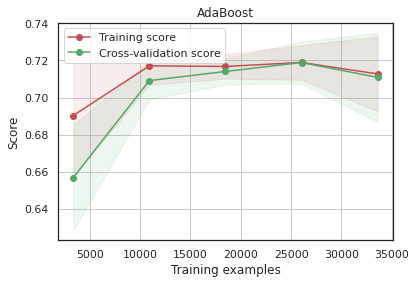

[1.7GB(+0.0GB): 70.458sec] Learning Curve: AdaBoost


In [80]:
with timer("Learning Curve: AdaBoost"):
    X_train, y_train = train[features], train[target]
    adb_clf = AdaBoostClassifier()
    plot_learning_curve(adb_clf, 'AdaBoost', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 8. Extra Tree

In [82]:
ext_clf = ExtraTreesClassifier()
SingleTraining(ext_clf, train[features], train[target],  title='Extra Tree', test_size=0.2, random_state=0)

Accuracy: 0.96678571


[2.2GB(+0.2GB): 15.247sec] Extra Tree


0.9667857142857142

In [83]:
X_train, y_train = train[features], train[target]
ext_clf = ExtraTreesClassifier()
ext_scores = cross_validation(ext_clf, X_train, y_train, title='Extra Tree', cv=10)
clf_cv_list['ext_clf'] = ext_scores

Acc Mean: 0.96830952 / Std: 0.00264157


[1.8GB(+0.0GB): 34.462sec] Extra Tree


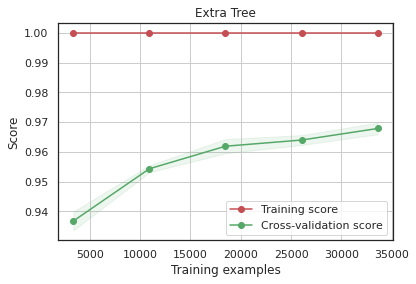

[1.8GB(+0.0GB): 47.077sec] Learning Curve: Extra Tree


In [84]:
with timer("Learning Curve: Extra Tree"):
    X_train, y_train = train[features], train[target]
    ext_clf = ExtraTreesClassifier()
    plot_learning_curve(ext_clf, 'Extra Tree', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 9. XGBoost

In [86]:
xgb_clf = XGBClassifier()
SingleTraining(xgb_clf, train[features], train[target],  title='XGBoost', test_size=0.2, random_state=0)

[21:18:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.97333333


[2.2GB(+0.2GB): 99.665sec] XGBoost


0.9733333333333334

In [ ]:
X_train, y_train = train[features], train[target]
xgb_clf = XGBClassifier()
xgb_scores = cross_validation(xgb_clf, X_train, y_train, title='XGBoost', cv=10)
clf_cv_list['xgb_clf'] = xgb_scores

In [ ]:
with timer("Learning Curve: XGBoost"):
    X_train, y_train = train[features], train[target]
    ext_clf = ExtraTreesClassifier()
    plot_learning_curve(ext_clf, 'XGBoost', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## 10. Logistic Regression (softmax)

In [88]:
lr_clf = LogisticRegression()
SingleTraining(lr_clf, train[features], train[target],  title='Logistic Regression', test_size=0.2, random_state=0)

Accuracy: 0.92023810


[2.3GB(+0.3GB): 9.509sec] Logistic Regression


0.9202380952380952

In [89]:
X_train, y_train = train[features], train[target]
lr_clf = LogisticRegression()
lr_scores = cross_validation(lr_clf, X_train, y_train, title='Logistic Regression', cv=10)
clf_cv_list['lr_clf'] = lr_scores

Acc Mean: 0.91992857 / Std: 0.00254673


[2.1GB(+0.0GB): 30.254sec] Logistic Regression


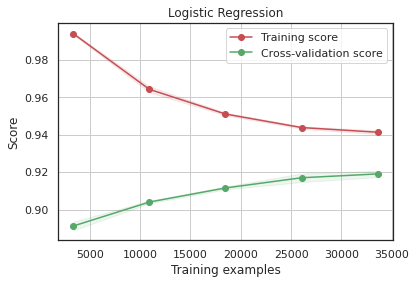

[2.1GB(+0.0GB): 42.737sec] Learning Curve: Logistic Regression


In [90]:
with timer("Learning Curve: Logistic Regression"):
    X_train, y_train = train[features], train[target]
    lr_clf = LogisticRegression()
    plot_learning_curve(lr_clf, 'Logistic Regression', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

# 11. Multiple Layer Perceptron

In [93]:
mlp_clf = MLPClassifier()
SingleTraining(mlp_clf, train[features], train[target],  title='MLP', test_size=0.2, random_state=0)

Accuracy: 0.97261905


[1.8GB(+0.2GB): 63.725sec] MLP


0.9726190476190476

In [94]:
X_train, y_train = train[features], train[target]
mlp_clf = MLPClassifier()
mlp_scores = cross_validation(mlp_clf, X_train, y_train, title='MLP', cv=10)
clf_cv_list['mlp_clf'] = mlp_scores

Acc Mean: 0.97400000 / Std: 0.00290593


[1.3GB(+0.0GB): 155.295sec] MLP


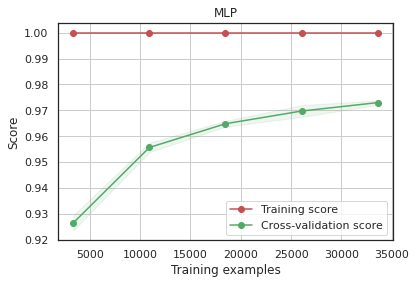

[1.3GB(-0.0GB): 231.822sec] Learning Curve: MLP


In [95]:
with timer("Learning Curve: MLP"):
    X_train, y_train = train[features], train[target]
    mlp_clf = MLPClassifier()
    plot_learning_curve(mlp_clf, 'MLP', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5))

## Summary

In [96]:
clf_cv_list

{'lgbm_clf': array([0.97761905, 0.97166667, 0.97809524, 0.97380952, 0.97666667,
        0.96785714, 0.97119048, 0.97333333, 0.97428571, 0.9747619 ]),
 'rf_clf': array([0.96642857, 0.96285714, 0.96857143, 0.96642857, 0.96714286,
        0.96190476, 0.96285714, 0.96928571, 0.96642857, 0.96595238]),
 'SVC': array([0.97857143, 0.97404762, 0.98119048, 0.97547619, 0.97642857,
        0.97166667, 0.97404762, 0.9802381 , 0.98095238, 0.975     ]),
 'dt_clf': array([0.86      , 0.8552381 , 0.86261905, 0.85833333, 0.85714286,
        0.85333333, 0.8497619 , 0.85785714, 0.85952381, 0.86166667]),
 'kNN_clf': array([0.97190476, 0.96785714, 0.96666667, 0.96785714, 0.96642857,
        0.96190476, 0.96452381, 0.96571429, 0.97261905, 0.96833333]),
 'adb_clf': array([0.725     , 0.70357143, 0.72547619, 0.72071429, 0.71404762,
        0.715     , 0.71642857, 0.70261905, 0.72571429, 0.73928571]),
 'ext_clf': array([0.97119048, 0.96547619, 0.97142857, 0.96904762, 0.96785714,
        0.96309524, 0.96690476, 

In [99]:
cv_mean  = []
cv_std   = []
cv_name  = []
clf_name = {'lgbm_clf':'Light GBM', 'rf_clf':'Random Forest', 'SVC':"Support Vector Machine",
            'dt_clf':'Decision Tree', 'kNN_clf':'K-Neighbors', 'adb_clf':'AdaBoost', 
            'ext_clf':'Extra Tree', 'lr_clf':'Logistic Regression', 'mlp_clf':'MLP'}
for clf in clf_cv_list.keys():
    cv = clf_cv_list[clf]
    cv_mean.append(np.mean(cv))
    cv_std.append(np.std(cv))
    cv_name.append(clf_name[clf])
    print("{0:25s}:{1}->{2:.3f}, {3:.5f}".format(clf_name[clf], np.round(cv,3), np.mean(cv), np.std(cv)))

Light GBM                :[0.978 0.972 0.978 0.974 0.977 0.968 0.971 0.973 0.974 0.975]->0.974, 0.00299
Random Forest            :[0.966 0.963 0.969 0.966 0.967 0.962 0.963 0.969 0.966 0.966]->0.966, 0.00235
Support Vector Machine   :[0.979 0.974 0.981 0.975 0.976 0.972 0.974 0.98  0.981 0.975]->0.977, 0.00313
Decision Tree            :[0.86  0.855 0.863 0.858 0.857 0.853 0.85  0.858 0.86  0.862]->0.858, 0.00370
K-Neighbors              :[0.972 0.968 0.967 0.968 0.966 0.962 0.965 0.966 0.973 0.968]->0.967, 0.00303
AdaBoost                 :[0.725 0.704 0.725 0.721 0.714 0.715 0.716 0.703 0.726 0.739]->0.719, 0.01044
Extra Tree               :[0.971 0.965 0.971 0.969 0.968 0.963 0.967 0.97  0.971 0.967]->0.968, 0.00264
Logistic Regression      :[0.922 0.922 0.919 0.92  0.92  0.916 0.917 0.918 0.92  0.925]->0.920, 0.00255
MLP                      :[0.978 0.972 0.975 0.972 0.978 0.971 0.969 0.975 0.977 0.973]->0.974, 0.00291


In [103]:
cv_result = pd.DataFrame({"Algorithm":cv_name, "CrossValMeans":cv_mean, "CrossValerrors": cv_std})

In [104]:
cv_result

,Algorithm,CrossValMeans,CrossValerrors
0,Light GBM,0.973929,0.002986
1,Random Forest,0.965786,0.002352
2,Support Vector Machine,0.976762,0.003132
3,Decision Tree,0.857548,0.003704
4,K-Neighbors,0.967381,0.003027
5,AdaBoost,0.718786,0.010443
6,Extra Tree,0.968310,0.002642
7,Logistic Regression,0.919929,0.002547
8,MLP,0.974000,0.002906


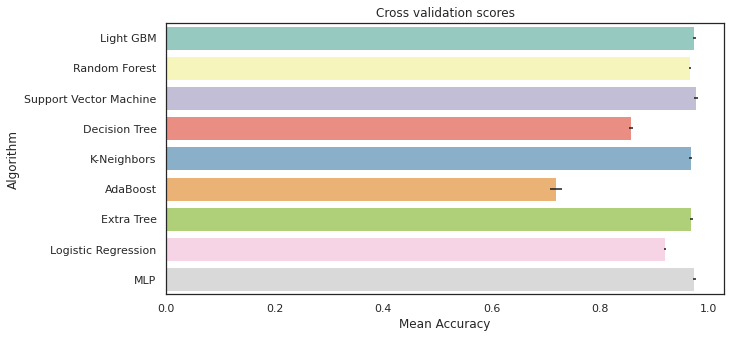

In [105]:
plt.figure(figsize=(10,5))
sns.barplot("CrossValMeans", "Algorithm", data = cv_result, palette="Set3", orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.show()